# Navigation Environment Construction - 2D

Boundaries.

Static obstacles.

Environment Visualization.


In [1]:
import sys
sys.path.append('../')
from panav.env import NavigationEnv, Box2DObstacle, PolygonObstacle
from panav.viz import draw_env
%load_ext autoreload
%autoreload 2

In [16]:
import shapely
import numpy as np
from matplotlib import pyplot as plt

start_locs = np.array([[-1,-1]])
goal_locs = np.array([[9,9]])


start_box_side = [1,1]
goal_box_side = [1,1]

starts = []
for s in start_locs:
    xl = start_box_side[0]
    yl = start_box_side[1]
    start_region = shapely.geometry.box(s[0]-xl/2,s[1]-yl/2
                                       ,s[0]+xl/2,s[1]+yl/2)
    starts.append(start_region)

goals = []
for g in goal_locs:
    xl = goal_box_side[0]
    yl = goal_box_side[1]
    goal_region = shapely.geometry.box(g[0]-xl/2,g[1]-yl/2
                                       ,g[0]+xl/2,g[1]+yl/2)
    goals.append(goal_region)

    

In [17]:
limits = [(-10.0,10.0),(-10.0,10.0)]
o=Box2DObstacle((0,3),(0,5))
p = PolygonObstacle([[6,1],[10,2],[6,5]])
env = NavigationEnv(limits,[o,p],starts,goals)

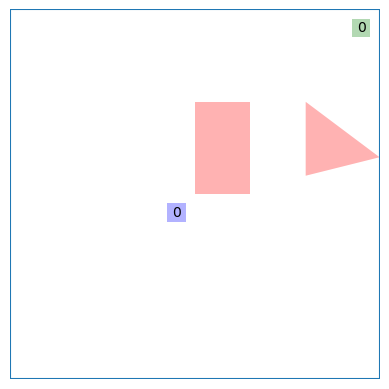

In [33]:
draw_env(env)